# prefectを使ってみよう

In [2]:
from prefect import task, Flow

import sys,os
sys.path.append('/home/work/example/prefect_tutorials')
import aircraftlib as aclib

In [3]:
@task
def extract_reference_data():
    print("fetching reference data...")
    return aclib.fetch_reference_data()


@task
def extract_live_data():
    # Get the live aircraft vector data around Dulles airport
    dulles_airport_position = aclib.Position(lat=38.9519444444, long=-77.4480555556)
    area_surrounding_dulles = aclib.bounding_box(dulles_airport_position, radius_km=200)

    print("fetching live aircraft data...")
    raw_aircraft_data = aclib.fetch_live_aircraft_data(area=area_surrounding_dulles)

    return raw_aircraft_data


@task
def transform(raw_aircraft_data, ref_data):
    print("cleaning & transform aircraft data...")

    live_aircraft_data = []
    for raw_vector in raw_aircraft_data:
        vector = aclib.clean_vector(raw_vector)
        if vector:
            aclib.add_airline_info(vector, ref_data.airlines)
            live_aircraft_data.append(vector)

    return live_aircraft_data


@task
def load_reference_data(ref_data):
    print("saving reference data...")
    db = aclib.Database()
    db.update_reference_data(ref_data)


@task
def load_live_data(live_aircraft_data):
    print("saving live aircraft data...")
    db = aclib.Database()
    db.add_live_aircraft_data(live_aircraft_data)


In [4]:
with Flow("etl") as flow:
    reference_data = extract_reference_data()
    live_data = extract_live_data()

    transformed_live_data = transform(live_data, reference_data)

    load_reference_data(reference_data)
    load_live_data(transformed_live_data)

flow.run()

[2021-07-04 16:35:52+0900] INFO - prefect.FlowRunner | Beginning Flow run for 'etl'
[2021-07-04 16:35:53+0900] INFO - prefect.TaskRunner | Task 'extract_reference_data': Starting task run...
fetching reference data...
[2021-07-04 16:35:53+0900] INFO - prefect.TaskRunner | Task 'extract_reference_data': Finished task run for task with final state: 'Success'
[2021-07-04 16:35:53+0900] INFO - prefect.TaskRunner | Task 'extract_live_data': Starting task run...
fetching live aircraft data...
[2021-07-04 16:35:53+0900] INFO - prefect.TaskRunner | Task 'extract_live_data': Finished task run for task with final state: 'Success'
[2021-07-04 16:35:53+0900] INFO - prefect.TaskRunner | Task 'transform': Starting task run...
cleaning & transform aircraft data...
[2021-07-04 16:35:53+0900] INFO - prefect.TaskRunner | Task 'transform': Finished task run for task with final state: 'Success'
[2021-07-04 16:35:53+0900] INFO - prefect.TaskRunner | Task 'load_live_data': Starting task run...
saving live a

<Success: "All reference tasks succeeded.">

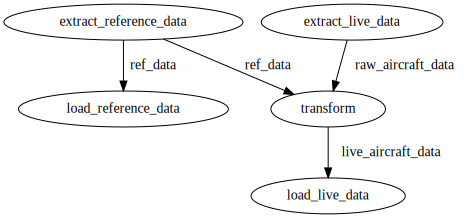

In [5]:
flow.visualize()